In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

from TransformerModel import TimeSeriesTransformer, grid_search
from torch.utils.data import TensorDataset
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves
from torch.utils.data import random_split

In [4]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# 准备数据，训练模型时会对train做k-fold。
df_train = pd.read_csv ('../TockFormerData\SPY_1hour_train.csv')
X, y, scaler, target_indices = create_sequences (df_train, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                                 scale=True)
train_dataset = TensorDataset (X, y)
sample_dataset = sample_dataset (train_dataset, 0.1)

数据被缩放


In [6]:
df_test = pd.read_csv ('../TockFormerData\SPY_1hour_test.csv')
X_t, y_t, _, _ = create_sequences (df_test, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                   scaler=scaler)
test_dataset = TensorDataset (X_t, y_t)

数据被缩放


In [7]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Sample dataset size: {len(sample_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")

Train dataset size: 19639
Sample dataset size: 1963
Test dataset size: 231


In [6]:
# 定义网格搜索，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    train_dataset,
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

Testing architecture params: {'model_dim': 64, 'num_heads': 2, 'num_layers': 2}
=== Fold 1/3 ===
Using device: cuda


KeyboardInterrupt: 

In [8]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params = {'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

model = TimeSeriesTransformer (**best_params)

best_params

{'model_dim': 64,
 'num_heads': 4,
 'num_layers': 3,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

In [9]:
# 重新整理数据，抽取10% 做validate，剩下的为train

total_len = len (train_dataset)
val_len = int (0.1 * total_len)
train_len = total_len - val_len

# 使用 random_split 划分数据集
train_subset, val_subset = random_split (train_dataset, [train_len, val_len])

df_val = pd.read_csv ('../TockFormerData\SPY_1hour_validate.csv')
X_val, y_val, _, _ = create_sequences (df_val, seq_length=32, target_cols=['open', 'high', 'low', 'close'],
                                       scaler=scaler)
val_dataset = TensorDataset (X_val, y_val)

数据被缩放


In [10]:
# 如果表现优异，对整体进行 train
model = TimeSeriesTransformer (**best_params)
train_loss, mse_list_train, r2_list_train = model.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 356. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 467. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 517. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 567. Reshuffling training data.
Epoch 1/50, Train Loss: 0.010561
Epoch 1/50, Val MSEs: [4408.06689453125, 2048.621337890625, 2887.49560546875, 3936.63623046875], R²: [-799.2801513671875, -402.43023681640625, -399.68927001953125, -822.46240234375]
Epoch 2: Bad batch threshold reached at batch 168. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 270. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 320. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 370. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 433. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 483. Reshuffling t

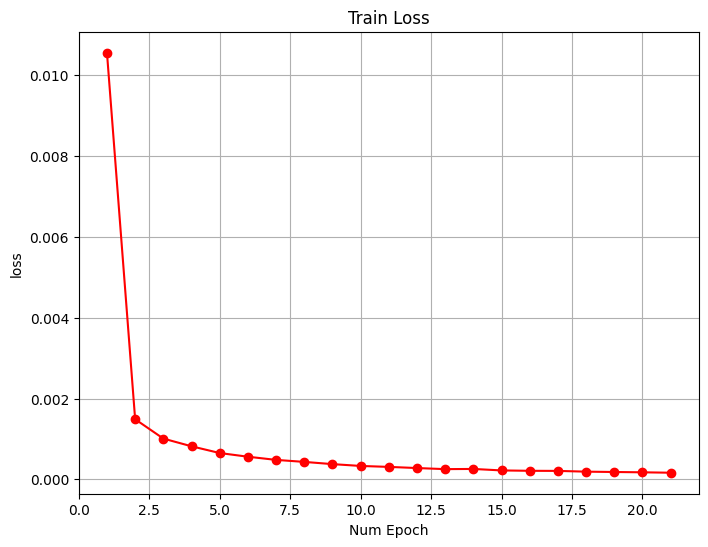

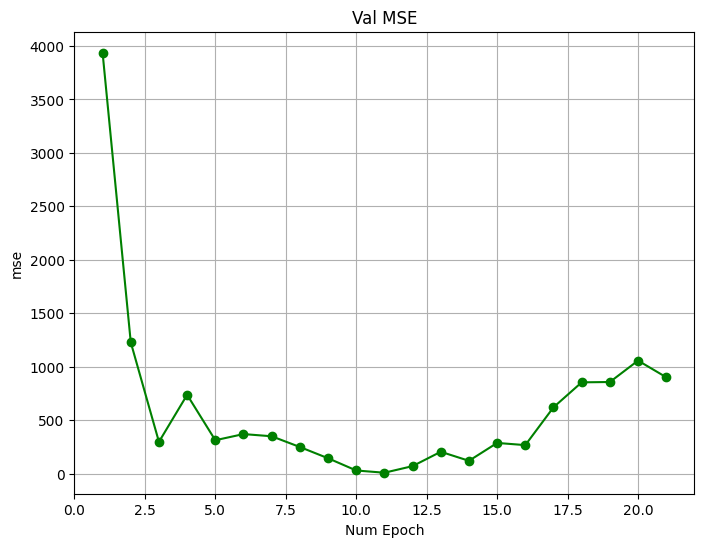

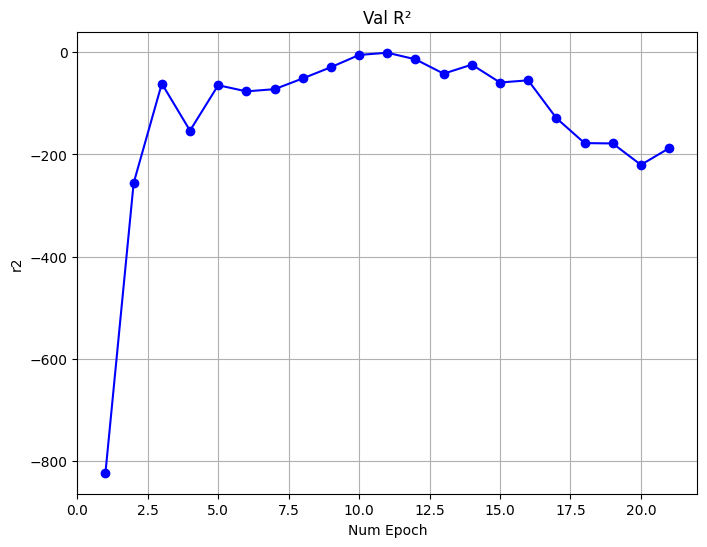

In [11]:
# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [55.2957878112793, 226.88673400878906, 89.71029663085938, 52.66178894042969]
测试集 R²:  [-0.2862902879714966, -4.597110271453857, -0.945701003074646, -0.22120451927185059]


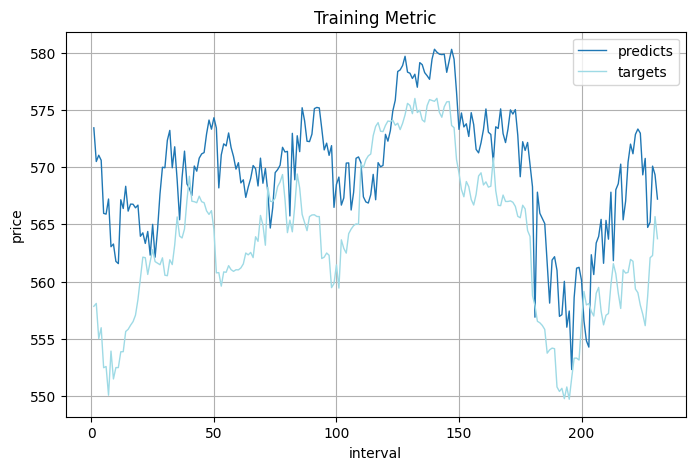

In [12]:
# 对test 进行测试
mse_list_test, r2_list_test, preds_test, targets = model.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_test)
print ("测试集 R²: ", r2_list_test)

curve_dict = {}
curve_dict['predicts'] = preds_test[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [64]:
from BiasCorrector import BiasCorrector
from sklearn.metrics import mean_squared_error, r2_score


x_tensor = val_dataset.tensors[0]  # 输入特征
y_tensor = val_dataset.tensors[1]  # 对应标签

y = model.safe_inverse_transform(y_tensor.numpy(), scaler=scaler, target_indices=target_indices)

# 使用 base model 进行预测（注意需要 batch 预测，如果模型较大）
preds_val = model.predict_model(x_tensor, scaler=scaler, bias_corrector=None, target_indices=target_indices)  # shape: (N, num_targets)


mlp_corrector = BiasCorrector(mode='mean', scale='None')
mlp_corrector.fit(preds_val, y)


测试集 MSE:  [86.03108215332031, 43.69826889038086, 65.574462890625, 39.17850875854492]
测试集 R²:  [-1.0012543201446533, -0.07800054550170898, -0.42222583293914795, 0.09146696329116821]


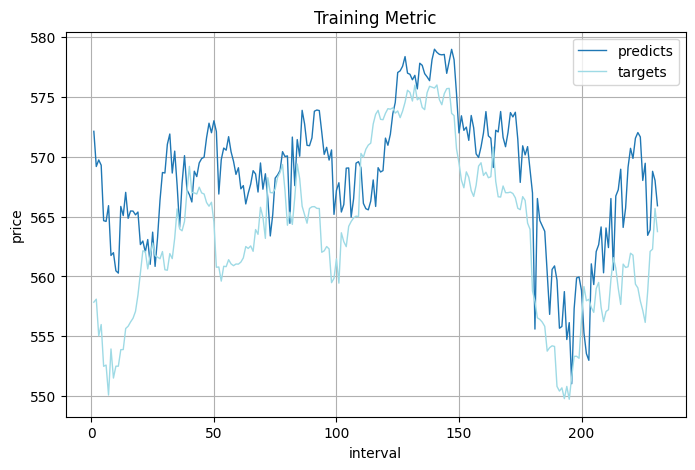

In [65]:
mse_list_cor, r2_list_cor, preds_cor, targets = model.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices,
                                                                        bias_corrector=mlp_corrector)

print ("测试集 MSE: ", mse_list_cor)
print ("测试集 R²: ", r2_list_cor)

curve_dict = {}
curve_dict['predicts'] = preds_cor[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)